# 1. Import Libraries

In [180]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# 2. Load Data

In [181]:
column_names = ["erythema", "scaling", "definite borders", "itching", "koebner phenomenon",
    "polygonal papules", "follicular papules", "oral mucosal involvement", "knee and elbow involvement",
    "scalp involvement", "family history", "melanin incontinence", "eosinophils in the infiltrate",
    "PNL infiltrate", "fibrosis of the papillary dermis", "exocytosis", "acanthosis",
    "hyperkeratosis", "parakeratosis", "clubbing of the rete ridges", "elongation of the rete ridges",
    "thinning of the suprapapillary epidermis", "spongiform pustule", "munro microabcess",
    "focal hypergranulosis", "disappearance of the granular layer", "vacuolisation and damage of basal layer",
    "spongiosis", "saw-tooth appearance of retes", "follicular horn plug", "perifollicular parakeratosis",
    "inflammatory monoluclear inflitrate", "band-like infiltrate", "Age", "class"
]

dermatology_data = pd.read_csv('dermatology/dermatology.data', header=None, names=column_names)

# 3. Data Preprocessing
## 3.1 Data replace and fill missing values
- Replace the missing values with NaN
- Convert the 'Age' column to numeric
- Fill the missing values in 'Age' with the median age
- Drop the 'perifollicular parakeratosis' column(because all values are 0)

In [182]:
# Replacing the missing values with NaN
dermatology_data.replace("?", pd.NA, inplace=True)
dermatology_data['Age'] = pd.to_numeric(dermatology_data['Age'], errors='coerce')

# Filling the missing values in 'Age' with the median age
age_median = dermatology_data['Age'].median()
dermatology_data['Age'].fillna(age_median, inplace=True)

# Dropping the 'perifollicular parakeratosis' column
dermatology_data.drop('perifollicular parakeratosis', axis=1, inplace=True)

## 3.2 Data visualization

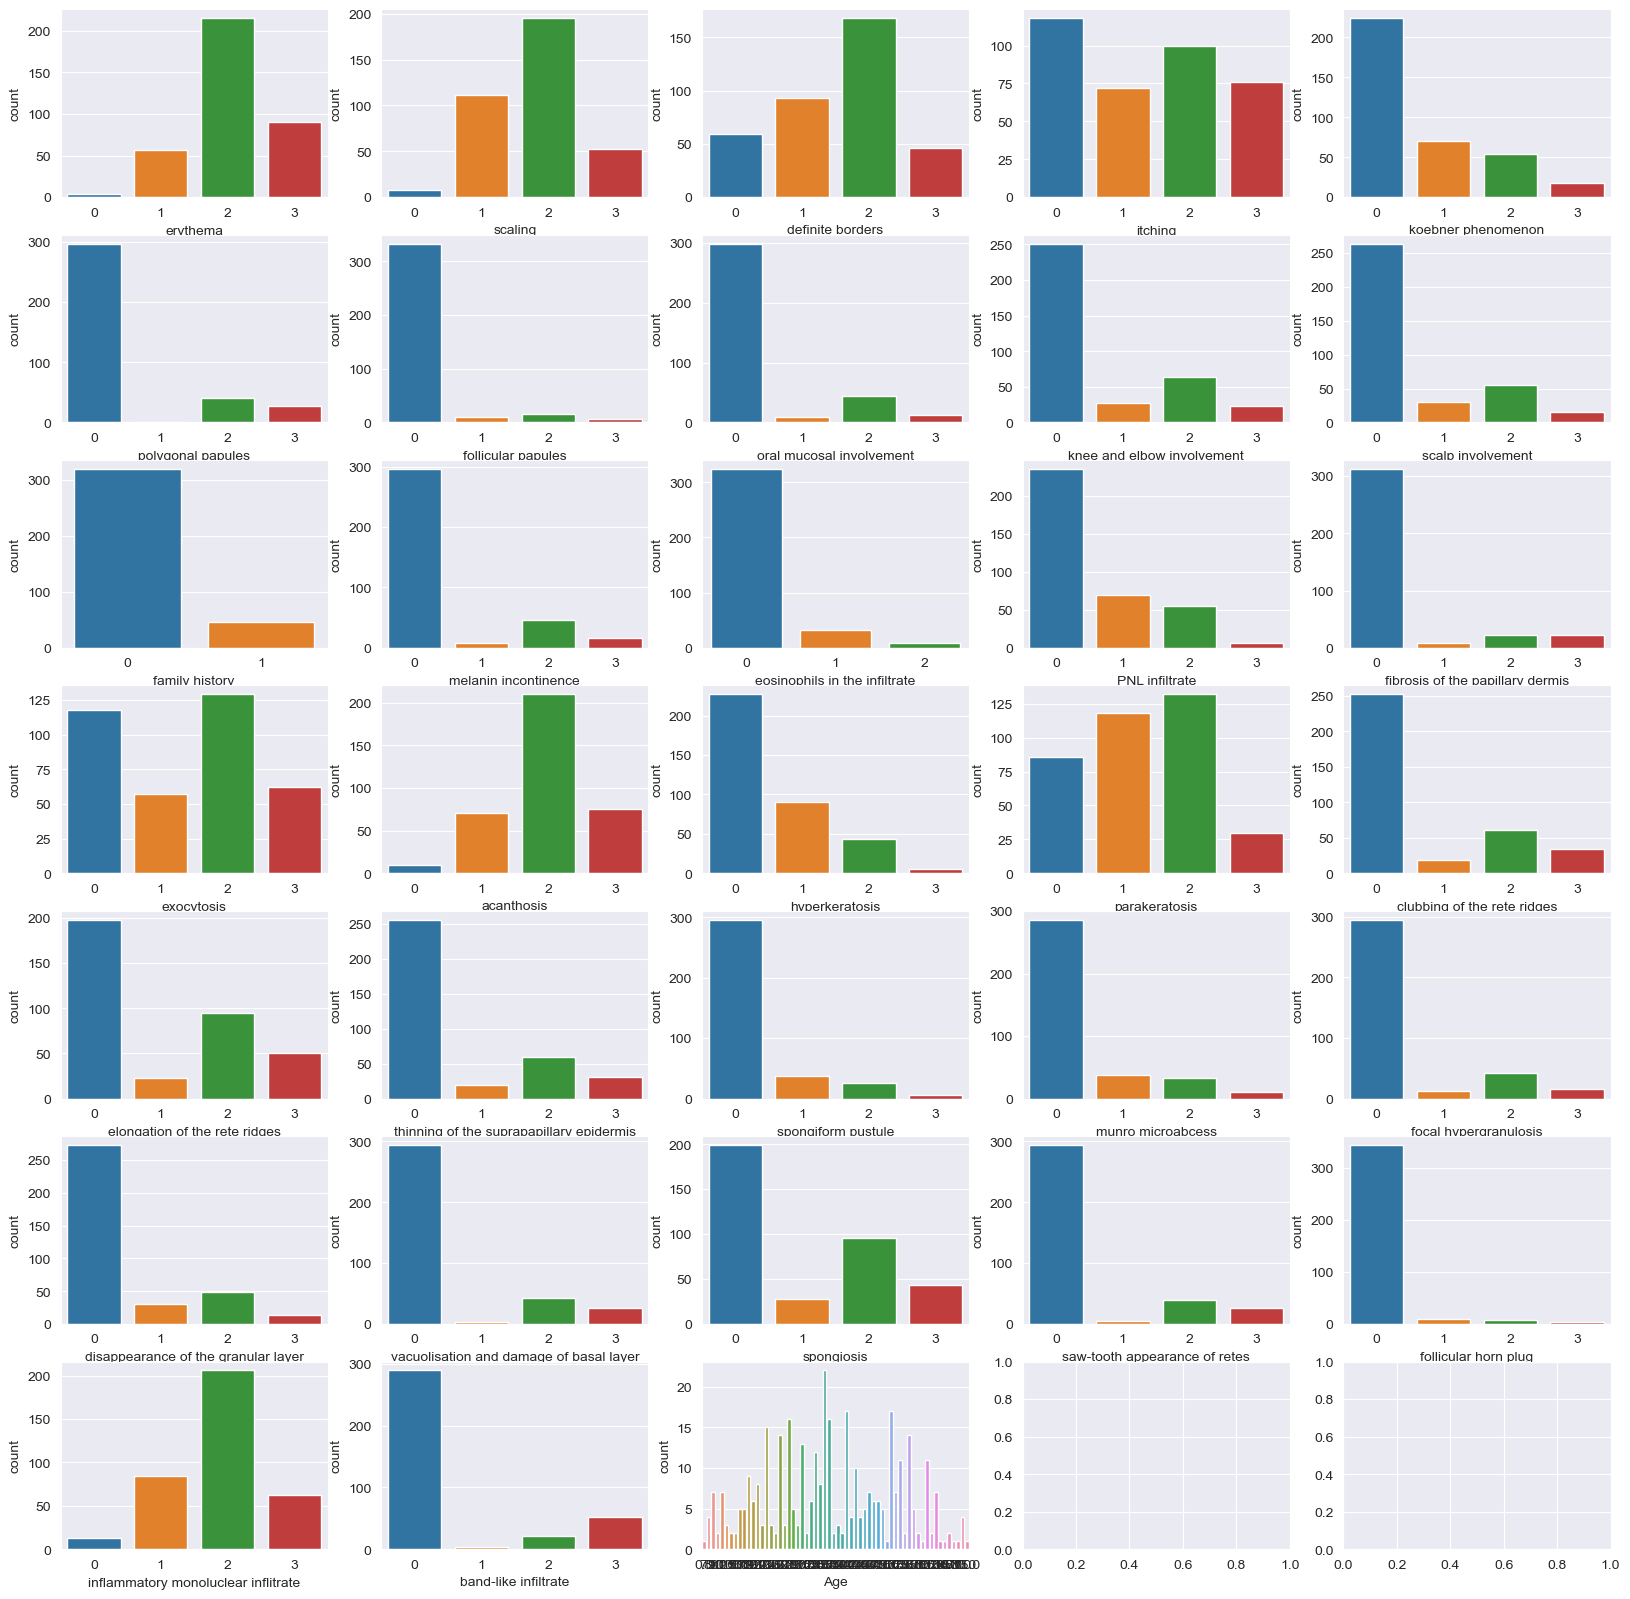

In [183]:
fig, ax = plt.subplots(7, 5, figsize=(20, 20))
for i, column in enumerate(dermatology_data.columns[:-1]):
    sns.countplot(x=column, data=dermatology_data, ax=ax[i//5][i%5])
plt.show()

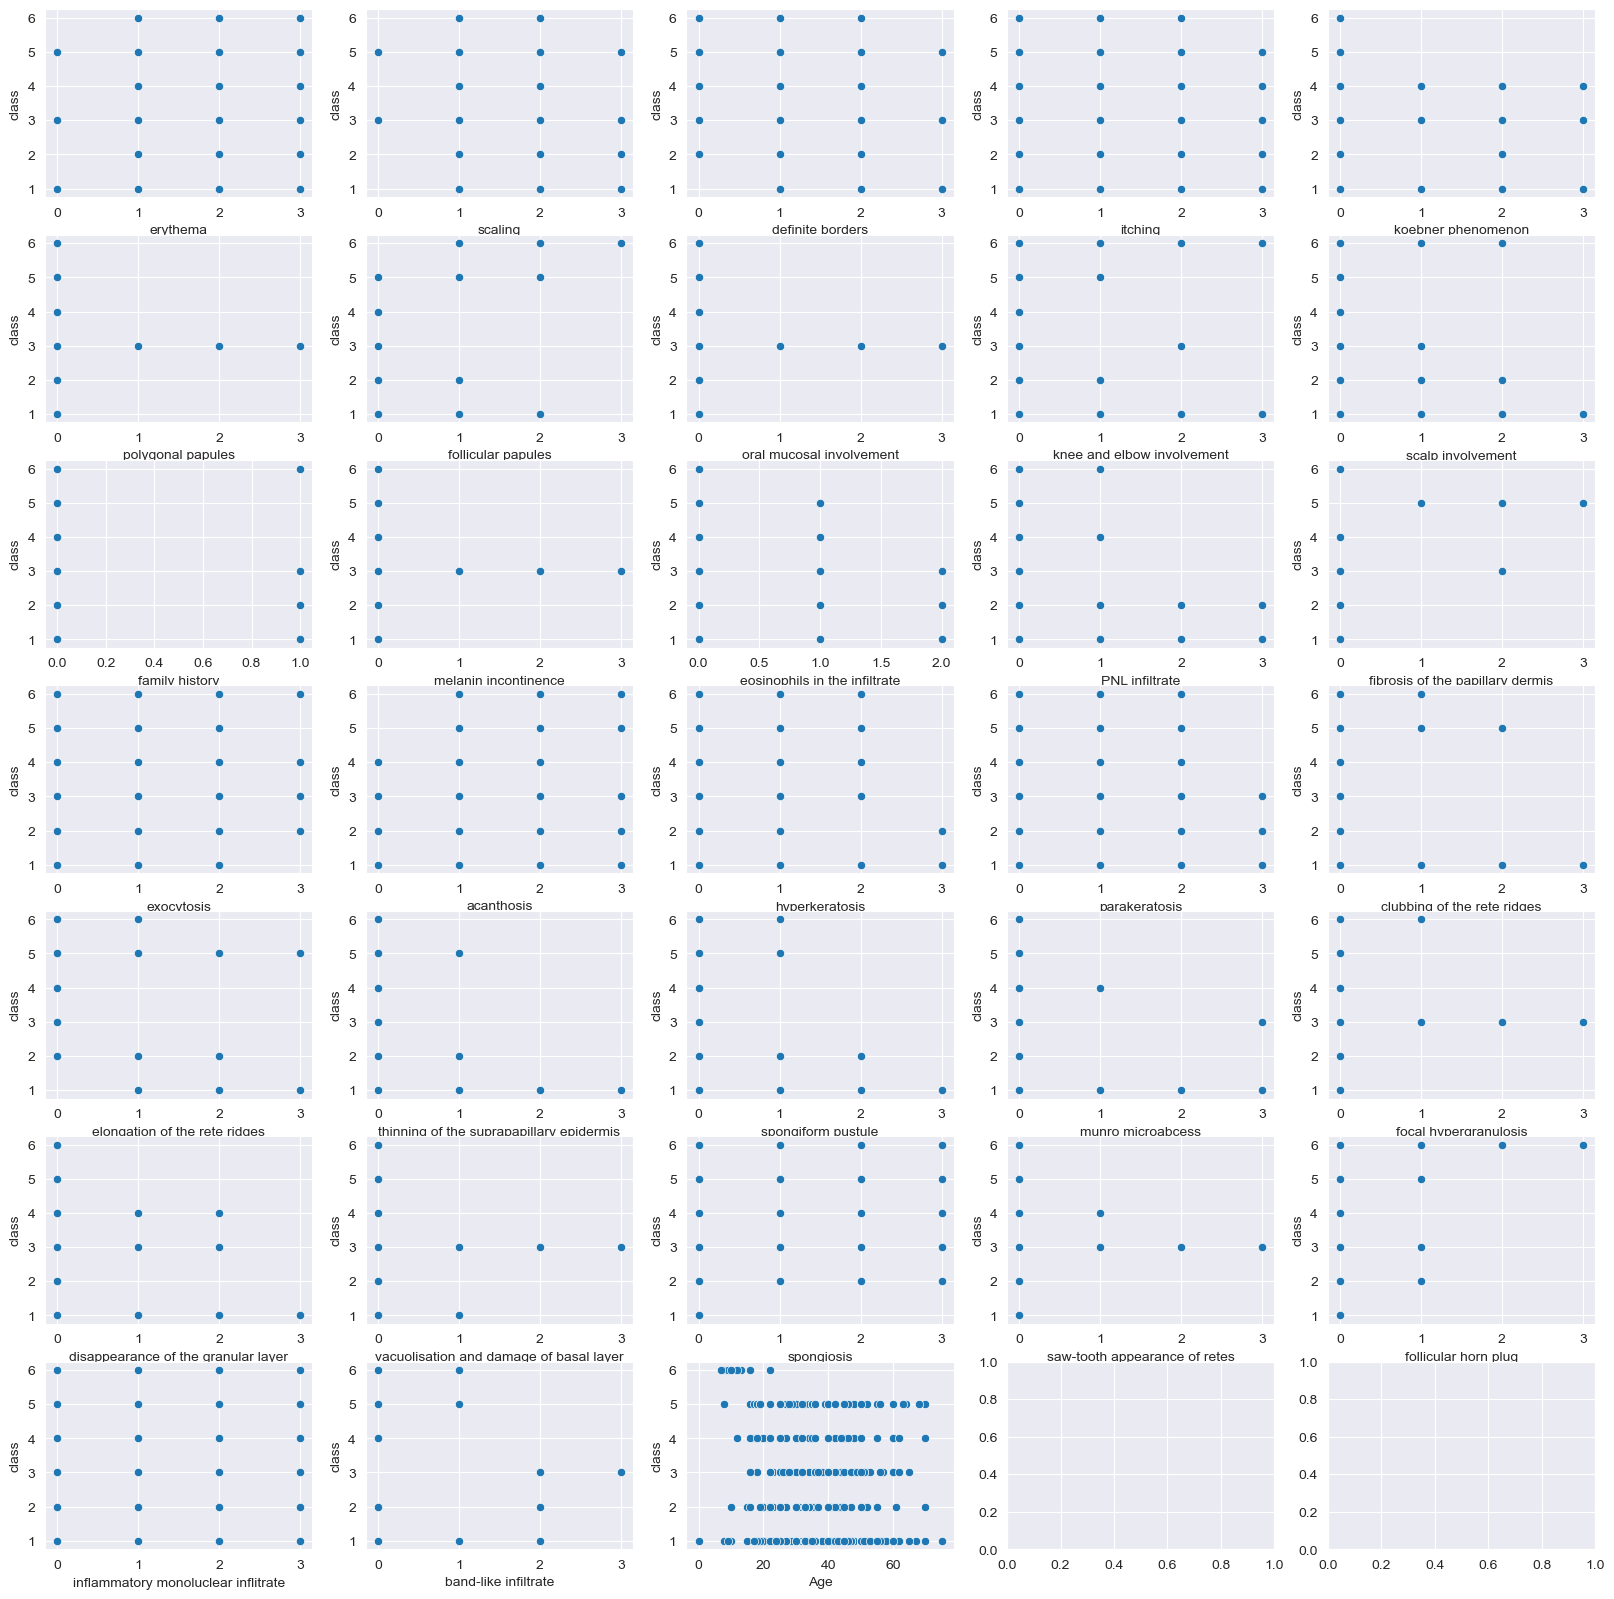

In [184]:
# plot the relationship between 'Age' and 'class'
fig, ax = plt.subplots(7, 5, figsize=(20, 20))
for i, column in enumerate(dermatology_data.columns[:-1]):
    sns.scatterplot(x=column, y='class', data=dermatology_data, ax=ax[i//5][i%5])
plt.show()

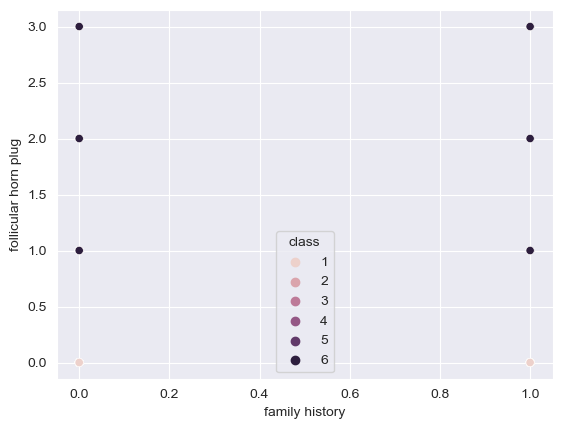

In [185]:
# 画出family history，follicular horn plug和class的关系，用不同颜色表示不同class
sns.scatterplot(x='family history', y='follicular horn plug', hue='class', data=dermatology_data)
plt.show()

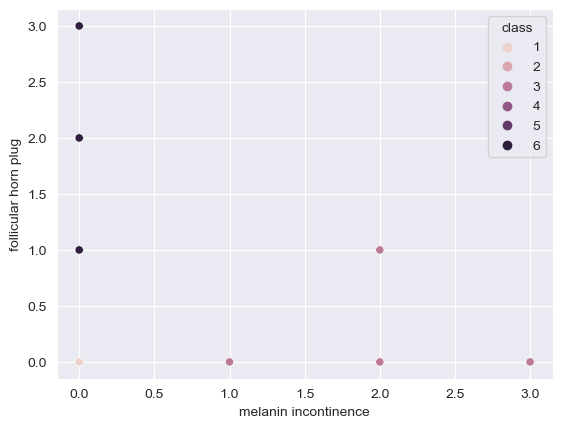

In [186]:
sns.scatterplot(x='melanin incontinence', y='follicular horn plug', hue='class', data=dermatology_data)
plt.show()

## 3.3 Data Scaling

In [187]:
dermatology_data_scaled = dermatology_data.copy()
for column in dermatology_data.columns[:-1]:
    col_min = dermatology_data[column].min()
    col_max = dermatology_data[column].max()
    dermatology_data_scaled[column] = (dermatology_data[column] - col_min) / (col_max - col_min)

## 3.4 Data Splitting
- Split the data into features and target
- One-hot encode the target, to get 6 output nodes
- Split the data into train and test sets

In [188]:
# Splitting the data into features and target
X = dermatology_data_scaled.drop('class', axis=1).values
y = dermatology_data_scaled['class'].values

# One-hot encoding the target, to get 6 output nodes, it will more fit to train ANN model
encoder = OneHotEncoder(sparse=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

/Users/zhaochengxin/anaconda3/envs/Learn/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# 4. ANN Model
## 4.1 Tools preparation
- I choose use sigmoid as my activation function
- I choose use cross-entropy as my loss function
- Due to the output is multi-class, I choose use softmax as my activation function for output layer

In [189]:
def sigmoid(x):
    """
    To compute the sigmoid function for the input x
    :param x: the input data
    :return: the sigmoid function for the input x
    """
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    """
    To compute the derivative of the sigmoid function for the input x
    :param x: the input data
    :return: the derivative of the sigmoid function for the input x
    """
    return x * (1 - x)

def softmax(x):
    """
    To compute the softmax function for the input x, due to the output is multi-class, I choose use softmax as my activation function in output layer
    :param x: the input data
    :return: the softmax function for the input x
    """
    e_x = np.exp(x)
    return e_x / e_x.sum(axis=1, keepdims=True)

def categorical_cross_entropy_loss(y_true, y_pred):
    """
    Due to the output is multi-class, I choose use cross-entropy as my loss function
    :param y_true: the true labels
    :param y_pred: the predicted labels
    :return: the cross-entropy loss for the input y_true and y_pred
    """
    return -np.sum(y_true * np.log(y_pred))

## 4.2 ANN implementation

In [190]:
class ANN:
    def __init__(self, input_size, hidden_size, output_size):
        """
        - I choose use 2 layers ANN model, the first layer is hidden layer, the second layer is output layer. I used the random "randn" function to initialize the weights to get more accuracy and help the model to fitting the data better.
        - For the bias, I used the zeros function to initialize the bias.
        :param input_size: the number of input nodes
        :param hidden_size: the number of hidden nodes
        :param output_size: the number of output nodes
        :return: None
        """
        self.weights1 = np.random.randn(input_size, hidden_size)
        self.bias1 = np.zeros((1, hidden_size))
        self.weights2 = np.random.randn(hidden_size, output_size)
        self.bias2 = np.zeros((1, output_size))
        
        self.cost_history = []

    def feedforward(self, X):
        """
        In the feedforward pass, the weighted sum of the inputs and the bias is computed for each node in the hidden layer. The result is then passed through the sigmoid activation function to get the output of the hidden layer. The same process is repeated for the output layer, but the activation function used is softmax.
        :param X: the input data - X
        :return: the output of the output layer
        """
        self.layer1 = sigmoid(np.dot(X, self.weights1) + self.bias1)
        self.output = softmax(np.dot(self.layer1, self.weights2) + self.bias2)
        return self.output

    def backpropagation(self, X, y, learning_rate):
        """
        In the backpropagation pass, the error is computed for the output layer. The weights and biases are then updated using the error and the learning rate. The same process is repeated for the hidden layer.
        :param X: the input data - X
        :param y: the target data - y
        :param learning_rate: the learning rate
        """

        """
        Calculate the error and delta for each layer, due to the output is multi-class, I choose use cross-entropy as my loss function and the softmax as my activation function for output layer, so the output_delta can equal to the output_error.
        """
        output_error = self.output - y
        output_delta = output_error

        layer1_error = output_delta.dot(self.weights2.T)
        layer1_delta = layer1_error * sigmoid_derivative(self.layer1)

        """
        Update the weights and bias for each layer
        """
        self.weights2 -= self.layer1.T.dot(output_delta) * learning_rate
        self.bias2 -= np.sum(output_delta, axis=0, keepdims=True) * learning_rate
        self.weights1 -= X.T.dot(layer1_delta) * learning_rate
        self.bias1 -= np.sum(layer1_delta, axis=0, keepdims=True) * learning_rate

    def train(self, X, y, epochs, learning_rate):
        """
        The train function is used to train the model for a specified number of epochs. The feedforward and backpropagation functions are called for each epoch. The loss is also computed for each epoch.
        :param X: the input data - X
        :param y: the target data(class) - y
        :param epochs: the number of epochs
        :param learning_rate: the learning rate
        """
        for epoch in range(epochs):
            self.feedforward(X)
            self.backpropagation(X, y, learning_rate)
            self.cost_history.append(categorical_cross_entropy_loss(y, self.output))
            
    def predict(self, X):
        """
        The predict function is used to predict the classes for the input data. The feedforward function is called to get the output of the output layer. The class with the highest probability is chosen as the predicted class.
        :param X: the input data - X
        :return: the predicted classes
        """
        output = self.feedforward(X)
        return np.argmax(output, axis=1)

# 5. Model Training

In [191]:
ann = ANN(X_train.shape[1], 10, y_train.shape[1])

ann.train(X_train, y_train, epochs=1000, learning_rate=0.01)

y_pred = ann.predict(X_test)

# To get the predicted labels, convert the one-hot encoded labels to integers
y_test_labels = np.argmax(y_test, axis=1)

# 6. Model Evaluation
## 6.1 Accuracy
I will calculate the accuracy of the model.
Accuracy is calculated as follows:
$$\( \text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}} \times 100 \) $$
Where:
- $\( \text{Number of correct predictions} \)$ is the number of correct predictions.
- $\( \text{Total number of predictions} \)$ is the number of all predictions.
- $\( \text{Accuracy} \)$ is the accuracy of the model.
- I will use the function below to calculate the accuracy of the model.

In [192]:
def accuracy(y_true, y_pred):
    """
    The accuracy function is used to compute the accuracy of the model.
    :param y_true: the true labels
    :param y_pred: the predicted labels
    :return: the accuracy of the model
    """
    return np.sum(y_true == y_pred) / len(y_true) * 100

print(f"Accuracy: {accuracy(y_test_labels, y_pred):.2f}%")

Accuracy: 98.65%


## 6.2 Loss Curve

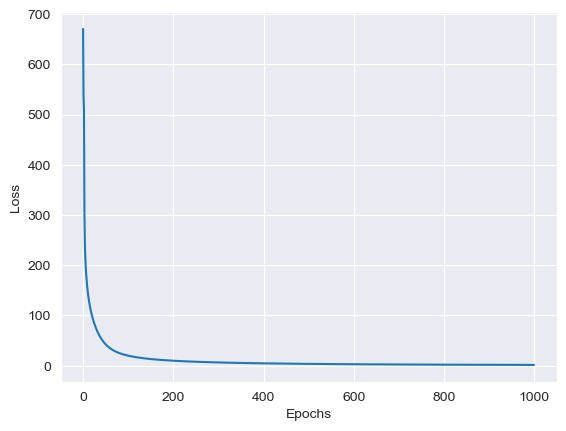

In [193]:
import matplotlib.pyplot as plt
plt.plot(range(1000), ann.cost_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## 6.3 Modify the hidden layer size

In [194]:
ann1 = ANN(X_train.shape[1], 2, y_train.shape[1])
ann1.train(X_train, y_train, epochs=1000, learning_rate=0.01)
y_pred1 = ann1.predict(X_test)
print(f"Accuracy: {accuracy(y_test_labels, y_pred1):.2f}%")

ann2 = ANN(X_train.shape[1], 5, y_train.shape[1])
ann2.train(X_train, y_train, epochs=1000, learning_rate=0.01)
y_pred2 = ann2.predict(X_test)
print(f"Accuracy: {accuracy(y_test_labels, y_pred2):.2f}%")

ann3 = ANN(X_train.shape[1], 10, y_train.shape[1])
ann3.train(X_train, y_train, epochs=1000, learning_rate=0.01)
y_pred3 = ann3.predict(X_test)
print(f"Accuracy: {accuracy(y_test_labels, y_pred3):.2f}%")

ann4 = ANN(X_train.shape[1], 20, y_train.shape[1])
ann4.train(X_train, y_train, epochs=1000, learning_rate=0.01)
y_pred4 = ann4.predict(X_test)
print(f"Accuracy: {accuracy(y_test_labels, y_pred4):.2f}%")

Accuracy: 95.95%
Accuracy: 98.65%
Accuracy: 98.65%
Accuracy: 98.65%


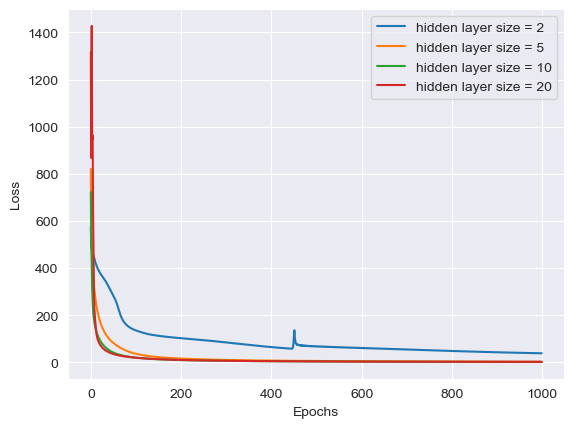

In [195]:
cost_history1 = ann1.cost_history
cost_history2 = ann2.cost_history
cost_history3 = ann3.cost_history
cost_history4 = ann4.cost_history

plt.plot(range(1000), cost_history1, label='hidden layer size = 2')
plt.plot(range(1000), cost_history2, label='hidden layer size = 5')
plt.plot(range(1000), cost_history3, label='hidden layer size = 10')
plt.plot(range(1000), cost_history4, label='hidden layer size = 20')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 6.4 Modify the learning rate

In [196]:
ann5 = ANN(X_train.shape[1], 10, y_train.shape[1])
ann5.train(X_train, y_train, epochs=1000, learning_rate=0.001)
y_pred5 = ann5.predict(X_test)
print(f"Accuracy: {accuracy(y_test_labels, y_pred5):.2f}%")

ann6 = ANN(X_train.shape[1], 10, y_train.shape[1])
ann6.train(X_train, y_train, epochs=1000, learning_rate=0.01)
y_pred6 = ann6.predict(X_test)
print(f"Accuracy: {accuracy(y_test_labels, y_pred6):.2f}%")

ann7 = ANN(X_train.shape[1], 10, y_train.shape[1])
ann7.train(X_train, y_train, epochs=1000, learning_rate=0.1)
y_pred7 = ann7.predict(X_test)
print(f"Accuracy: {accuracy(y_test_labels, y_pred7):.2f}%")

Accuracy: 98.65%
Accuracy: 98.65%
Accuracy: 41.89%


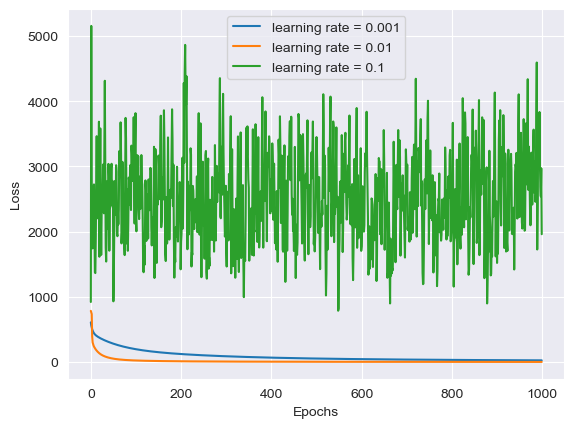

In [197]:
cost_history5 = ann5.cost_history
cost_history6 = ann6.cost_history
cost_history7 = ann7.cost_history

plt.plot(range(1000), cost_history5, label='learning rate = 0.001')
plt.plot(range(1000), cost_history6, label='learning rate = 0.01')
plt.plot(range(1000), cost_history7, label='learning rate = 0.1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 6.5 Modify the number of epochs

In [198]:
ann8 = ANN(X_train.shape[1], 10, y_train.shape[1])
ann8.train(X_train, y_train, epochs=100, learning_rate=0.01)
y_pred8 = ann8.predict(X_test)
print(f"Accuracy: {accuracy(y_test_labels, y_pred8):.2f}%")

ann9 = ANN(X_train.shape[1], 10, y_train.shape[1])
ann9.train(X_train, y_train, epochs=500, learning_rate=0.01)
y_pred9 = ann9.predict(X_test)
print(f"Accuracy: {accuracy(y_test_labels, y_pred9):.2f}%")

ann10 = ANN(X_train.shape[1], 10, y_train.shape[1])
ann10.train(X_train, y_train, epochs=1000, learning_rate=0.01)
y_pred10 = ann10.predict(X_test)
print(f"Accuracy: {accuracy(y_test_labels, y_pred10):.2f}%")

ann11 = ANN(X_train.shape[1], 10, y_train.shape[1])
ann11.train(X_train, y_train, epochs=2000, learning_rate=0.01)
y_pred11 = ann11.predict(X_test)
print(f"Accuracy: {accuracy(y_test_labels, y_pred11):.2f}%")

Accuracy: 98.65%
Accuracy: 98.65%
Accuracy: 98.65%
Accuracy: 98.65%


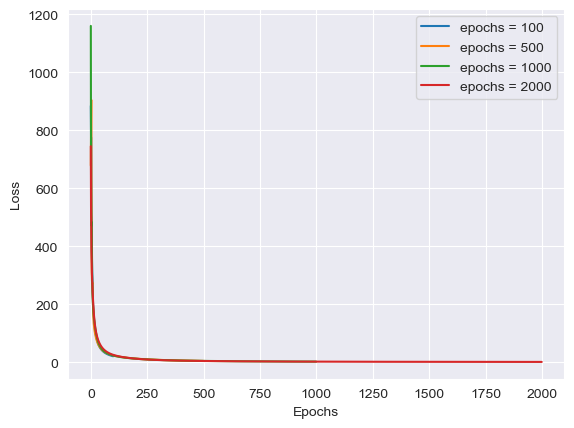

In [199]:
cost_history8 = ann8.cost_history
cost_history9 = ann9.cost_history
cost_history10 = ann10.cost_history
cost_history11 = ann11.cost_history

plt.plot(range(100), cost_history8, label='epochs = 100')
plt.plot(range(500), cost_history9, label='epochs = 500')
plt.plot(range(1000), cost_history10, label='epochs = 1000')
plt.plot(range(2000), cost_history11, label='epochs = 2000')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 6.6 Visualization of  Confusion matrix

Recall: [1.    1.    1.    0.875 1.    1.   ]
Precision: [1.  0.9 1.  1.  1.  1. ]
F1 Score: [1.         0.94736842 1.         0.93333333 1.         1.        ]


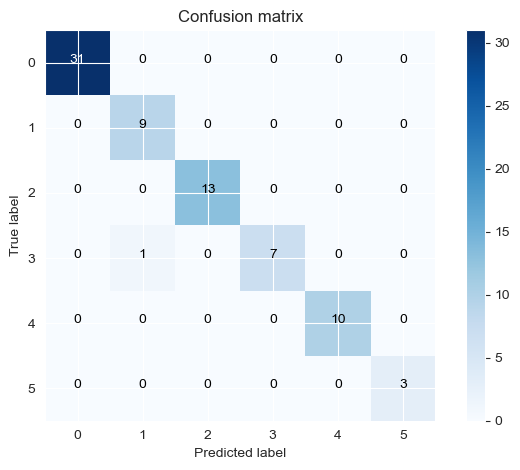

In [201]:
def confusion_matrix(y_true, y_pred):
    """
    The confusion_matrix function is used to compute the confusion matrix of the model.
    :param y_true: the true labels
    :param y_pred: the predicted labels
    :return: the confusion matrix of the model
    """
    num_classes = len(np.unique(y_true))
    result = np.zeros((num_classes, num_classes))
    for i in range(len(y_true)):
        result[y_true[i]][y_pred[i]] += 1
        
    true_positive = np.diag(result)
    false_positive = np.sum(result, axis=0) - true_positive
    false_negative = np.sum(result, axis=1) - true_positive
    
    recall = true_positive / (true_positive + false_negative)
    precision = true_positive / (true_positive + false_positive)
    f1_score = 2 * precision * recall / (precision + recall)
    
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1_score}")
    
    return result

def plot_confusion_matrix(cm, classes):
    """
    The plot_confusion_matrix function is used to plot the confusion matrix of the model.
    :param cm: the confusion matrix
    :param classes: the class labels
    """
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(int(cm[i, j])),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > cm.max() / 2. else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
plot_confusion_matrix(confusion_matrix(y_test_labels, y_pred), classes=np.unique(y_test_labels))